In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Tensorflow imports

# for building model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, GlobalMaxPooling1D, Dense, Dropout,BatchNormalization,Bidirectional

# for Padding
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for Tokenization 
from tensorflow.keras.preprocessing.text import Tokenizer

# NLTK imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For regular expressions
import re

# For data preprocessing
from string import punctuation, digits
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv("Corona_NLP_train.csv", encoding="Latin-1")
test_df = pd.read_csv("Corona_NLP_test.csv", encoding="Latin-1")

print(f"train dataset shape >> {train_df.shape}")
print(f"test dataset shape >> {test_df.shape}")

train dataset shape >> (41157, 6)
test dataset shape >> (3798, 6)


In [4]:
def data_label_split(dataset):
    data = dataset['OriginalTweet']
    label = dataset['Sentiment']
    return data,label

train_data,train_label = data_label_split(train_df)
test_data,test_label = data_label_split(test_df)

train = pd.DataFrame({
    'label':train_label,
    'data':train_data
})

test = pd.DataFrame({
    'label':test_label,
    'data':test_data
})

# Define function which will make new labels

def reassign_label(x):
    if x == "Extremely Positive" or x == "Positive":
        return 1
    elif x =="Extremely Negative" or x =="Negative":
        return -1
    elif x =="Neutral":
        return 0

train.label = train.label.apply(lambda x:reassign_label(x))
test.label = test.label.apply(lambda x:reassign_label(x))

In [5]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

In [6]:
nltk.download('stopwords')
train.data = train.data.apply(lambda sentence:clean_sentence(sentence))
test.data = test.data.apply(lambda sentence:clean_sentence(sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def rem_latin_a(sentences):
    sentences = sentences.replace("â", "")
    return sentences

train.data = train.data.apply(lambda sentences:rem_latin_a(sentences))
test.data = test.data.apply(lambda sentences:rem_latin_a(sentences))

In [8]:
train['data'].replace('', np.nan, inplace=True)
test['data'].replace('', np.nan, inplace=True)

In [9]:
# Discard null values

# Originally there were 41157 rows, now it has become 41106. The training dataset was reduced by 51 lines.
train.dropna(subset=['data'], inplace=True)

# Originally there were 3798 lines, now it has become 3795. The test dataset was reduced by 3 lines.
test.dropna(subset=['data'], inplace=True)

In [10]:
# Splitting data to train and test

# Train data
train_data = train.data
train_label = train.label

# Test data
test_data = test.data
test_label = test.label

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


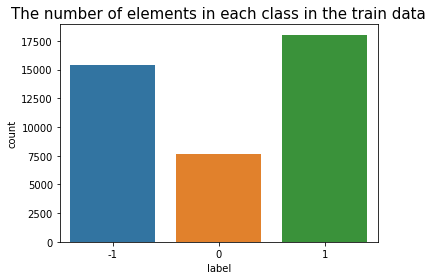

In [11]:
sns.countplot(x=train_label)
plt.title('The number of elements in each class in the train data', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.tight_layout()
plt.show()

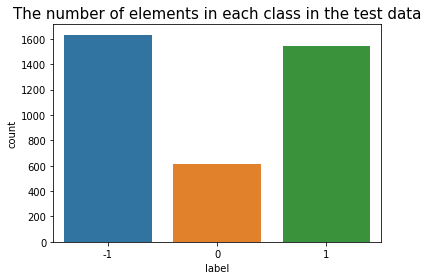

In [12]:
sns.countplot(x=test_label)
plt.title('The number of elements in each class in the test data', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.tight_layout()
plt.show()

In [13]:
train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

In [14]:
train_label

,-1,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,0
5,0,0,1
...,...,...,...
41152,0,1,0
41153,1,0,0
41154,0,0,1
41155,0,1,0


In [15]:
lemmatizer = WordNetLemmatizer()

# Function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function below is necessery to find lemma of each word
def lemmatize_sentence(de_punct_sent):
    # Tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(de_punct_sent))
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # If there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [16]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
train_lem = [lemmatize_sentence(i) for i in train_data]
test_lem = [lemmatize_sentence(i) for i in test_data]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
samples_1 = train_lem
samples_2 = test_lem

tokenizer = Tokenizer(num_words=25000) # 25 000 most frequently used words
tokenizer.fit_on_texts(samples_1) # Creat an index of all words from training data

# Convert strings to integer index lists

# After that, we pass the ready-made (from the line above) indexes for all words from train
train_data = tokenizer.texts_to_sequences(samples_1)

# And for test. So, we should get the same word indexes in the two texts
test_data = tokenizer.texts_to_sequences(samples_2)

word_index = tokenizer.word_index # Find out the calculated index of words
print('Found %s unique tokens.' % len(word_index))

Found 31903 unique tokens.


findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


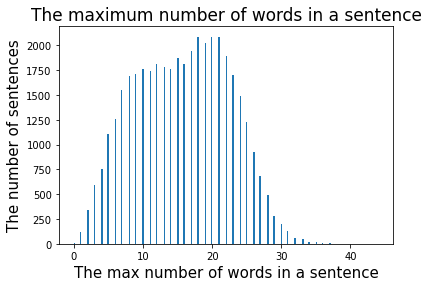

In [18]:

lens =  [len(s) for s in train_data]

plt.title('The maximum number of words in a sentence', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 17})
plt.xlabel('The max number of words in a sentence', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.ylabel('The number of sentences', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.hist(lens,bins=200)
plt.show()

In [19]:
maxlen = 40 # maximal length of sentences

# Convert lists of integers to a two-dimensional tensor 
# with integers and with a shape (samples, max. length)

train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post') 
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post')

In [20]:
embedding_dim = 256 # Dimension of the dense embedding.

vocab_inp_size = len(word_index) + 1 # Size of the vocabulary

hidden_size = 128

In [21]:
model = Sequential() 

# The Embedding layer is necessery in order to convert words (in out case from integers) to vectors
model.add(Embedding(input_dim = vocab_inp_size, output_dim = embedding_dim, input_length = maxlen))

# Apply Dropout to use recurrent decimation to combat overfitting 
model.add(Bidirectional(LSTM(hidden_size, return_sequences=True))) 

# Use Flatten() or GlobalMaxPooling1D() to convert 3D output to 2D.
# It allows you to add one or more Dense layers to your model 
model.add(Flatten()) 
# or

#model.add(Dense(64, activation='relu'))#as experiment we tried to add one additional layer,but it is not give as higher accuracy
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32,activation='relu'))
model.add(Dense(3, activation='softmax'))#activation function for classification
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(train_data, train_label, epochs=3 , batch_size = 128, validation_split=0.01)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 256)           8167424   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 256)           394240    
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1310848   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

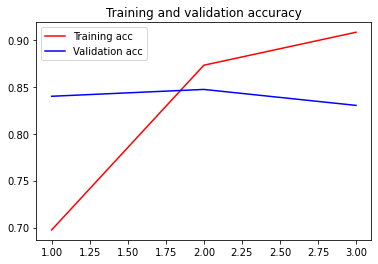

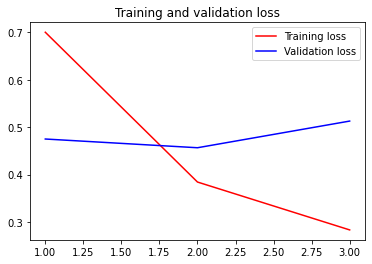

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
model.evaluate(test_data,test_label)

119/119 [==============================] - 1s 6ms/step - loss: 0.4987 - accuracy: 0.8274


[0.49866175651550293, 0.8274044990539551]

In [24]:
t=model.predict(test_data)
print(t)

[[9.3297267e-01 3.2453727e-02 3.4573644e-02]
 [2.9127803e-03 6.3220332e-03 9.9076521e-01]
 [1.5036172e-03 1.7433276e-04 9.9832207e-01]
 ...
 [2.4168235e-03 9.9730635e-01 2.7678840e-04]
 [9.9296266e-01 1.1855228e-03 5.8518345e-03]
 [2.9341499e-03 3.6341633e-04 9.9670237e-01]]


In [25]:
temp=[]
for i in t:
  if(i[0]> i[1] and i[0]>i[2]):
    temp.append([1,0,0])
  elif(i[1]>i[0] and i[1]>i[2]):
    temp.append([0,1,0])
  else:
    temp.append([0,0,1])


In [26]:
from sklearn.metrics import classification_report
print(classification_report(test_label,temp))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1633
           1       0.79      0.72      0.75       616
           2       0.84      0.85      0.84      1546

   micro avg       0.83      0.83      0.83      3795
   macro avg       0.82      0.81      0.81      3795
weighted avg       0.83      0.83      0.83      3795
 samples avg       0.83      0.83      0.83      3795

